#### Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
import pandas as pd 
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt 
from tensorflow.keras import layers, models
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True # this is because some image is truncated
# the bug will make the training process will failed

2024-06-30 07:18:27.103919: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-30 07:18:27.104080: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-30 07:18:27.280566: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
data_dir = Path('/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification')
train_dir = data_dir / 'train'
test_dir = data_dir / 'test'
val_dir = data_dir / 'val'

In [5]:
BATCH_SIZE = 32
IMG_HEIGHT = 180
IMG_WIDTH = 180

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                              image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              batch_size=BATCH_SIZE)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                              image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              batch_size=BATCH_SIZE)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(val_dir,
                                                              image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              batch_size=BATCH_SIZE)

Found 9246 files belonging to 2 classes.
Found 506 files belonging to 2 classes.
Found 829 files belonging to 2 classes.


In [7]:
class_names = train_ds.class_names
class_names

['fractured', 'not fractured']

In [8]:
class_names = train_ds.class_names

def show_images(dataset, title):
    plt.figure(figsize=(6, 6))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i+1)
            plt.imshow(images[i].numpy().astype('uint8'))
            plt.title(class_names[labels[i]])
            plt.axis('off')
    plt.suptitle(title)
    plt.show()

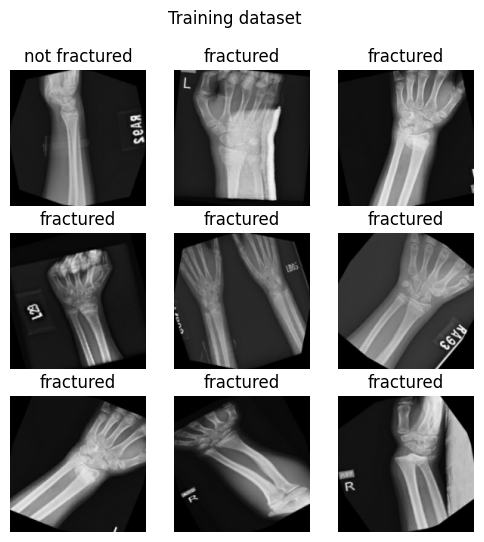

In [10]:
show_images(train_ds, 'Training dataset')

In [11]:
def count_classes(dataset, class_name):
    return len(list(Path.glob(dataset, f"{class_name}/*")))

def create_class_counts_df(dataset, class_names):
    counts = {'class':[], 'count': []}
    for class_name in class_names:
        counts['class'].append(class_name)
        counts['count'].append(count_classes(dataset, class_name))
    return pd.DataFrame(counts)

def plot_class_distribution(df, title, palette="viridis"):
    sns.barplot(x='class', y='count', data=df, palette=palette)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

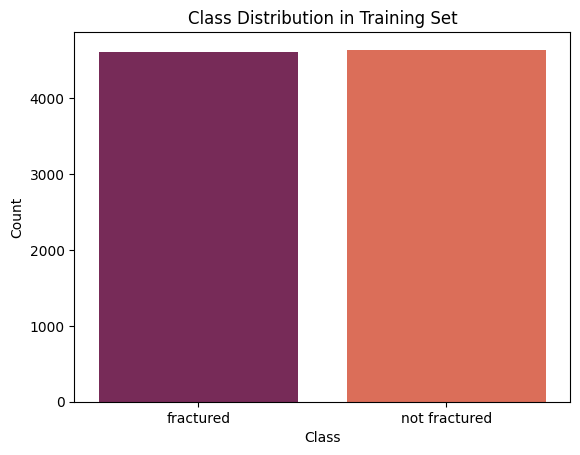

In [12]:
train_df = create_class_counts_df(train_dir, class_names)
plot_class_distribution(train_df, 'Class Distribution in Training Set', palette='rocket')

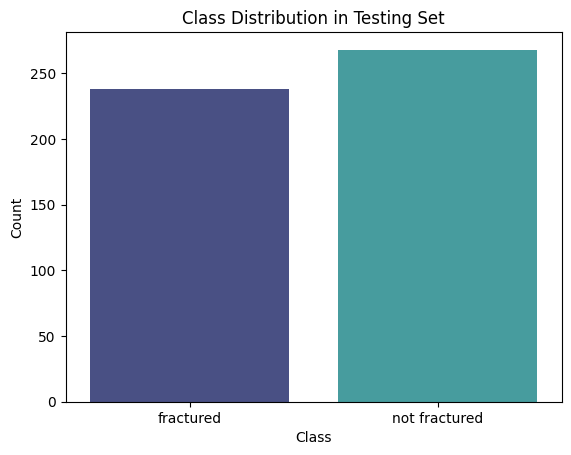

In [13]:
test_df = create_class_counts_df(test_dir, class_names)
plot_class_distribution(test_df, 'Class Distribution in Testing Set', palette='mako')

In [14]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [16]:
training_set = train_datagen.flow_from_directory(train_dir,
                                                target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                batch_size=32,
                                                class_mode='binary')

Found 9246 images belonging to 2 classes.


In [21]:
test_set = train_datagen.flow_from_directory(test_dir,
                                                target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                batch_size=32,
                                                class_mode='binary')

Found 506 images belonging to 2 classes.


In [17]:
val_set = train_datagen.flow_from_directory(val_dir,
                                                target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                batch_size=32,
                                                class_mode='binary')

Found 829 images belonging to 2 classes.


#### Create Model CNN

In [18]:
model_by_prasad = models.Sequential([
    layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model_by_prasad.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,647,105 (25.36 MB)

 Trainable params: 6,647,105 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model_by_prasad.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [23]:
history_by_prasad = model_by_prasad.fit(training_set,
                   validation_data=val_set, # modif from prasad (not using test_set for validation)
                   epochs=10
                   )

Epoch 1/10
288/289 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.7008 - loss: 0.5640

W0000 00:00:1719732174.604251     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


289/289 ━━━━━━━━━━━━━━━━━━━━ 149s 505ms/step - accuracy: 0.7013 - loss: 0.5635 - val_accuracy: 0.8347 - val_loss: 0.4183
Epoch 2/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 87s 295ms/step - accuracy: 0.8945 - loss: 0.2697 - val_accuracy: 0.8806 - val_loss: 0.3040
Epoch 3/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 87s 296ms/step - accuracy: 0.9366 - loss: 0.1701 - val_accuracy: 0.9083 - val_loss: 0.2362
Epoch 4/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 88s 296ms/step - accuracy: 0.9614 - loss: 0.1050 - val_accuracy: 0.9192 - val_loss: 0.2397
Epoch 5/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 87s 295ms/step - accuracy: 0.9725 - loss: 0.0791 - val_accuracy: 0.9156 - val_loss: 0.2382
Epoch 6/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 86s 293ms/step - accuracy: 0.9833 - loss: 0.0552 - val_accuracy: 0.9433 - val_loss: 0.1963
Epoch 7/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 87s 295ms/step - accuracy: 0.9822 - loss: 0.0505 - val_accuracy: 0.9457 - val_loss: 0.1561
Epoch 8/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 87s 294ms/step - accuracy: 0.9855 - loss: 0.0454 - va

In [26]:
test_loss_by_prasad, test_acc_by_prasad = model_by_prasad.evaluate(test_set)
print(f"Test Loss: {test_loss_by_prasad:.2f}")
print(f"Test Accurracy: {test_acc_by_prasad:.2f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 416ms/step - accuracy: 0.9867 - loss: 0.0323
Test Loss: 0.04
Test Accurracy: 0.98


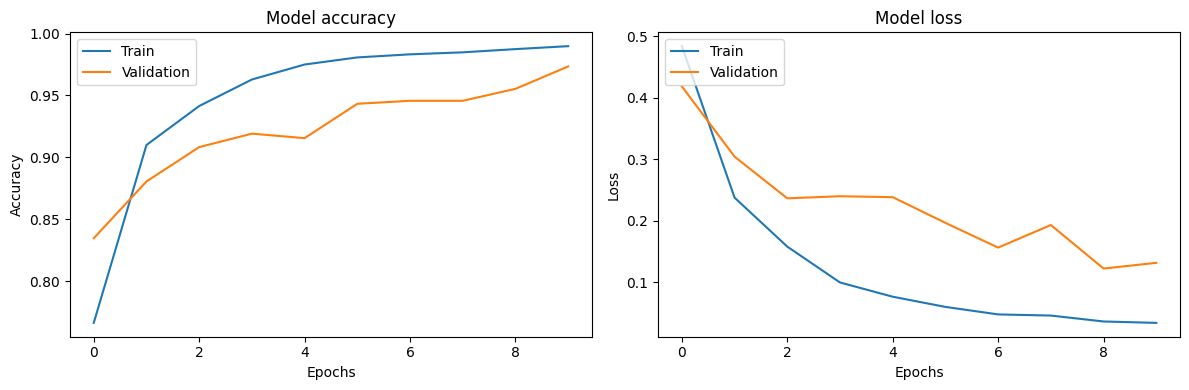

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_by_prasad.history['accuracy'])
plt.plot(history_by_prasad.history['val_accuracy'])
plt.title("Model accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_by_prasad.history['loss'])
plt.plot(history_by_prasad.history['val_loss'])
plt.title("Model loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [28]:
model_by_alkhatib = models.Sequential([
    layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
]) # same as prasad (not needed to run)

model_by_bagaria =  models.Sequential([
    layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(2, activation='softmax') # using softmax (Note: The class is same fracture / non-fracture)
])

model_by_bagaria.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,647,234 (25.36 MB)

 Trainable params: 6,647,234 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
model_by_bagaria.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [32]:
history_by_bagaria = model_by_bagaria.fit(training_set,
                   validation_data=val_set,
                   epochs=10
                   )

Epoch 1/10
288/289 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.7249 - loss: 0.5381

W0000 00:00:1719733331.131709     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


289/289 ━━━━━━━━━━━━━━━━━━━━ 90s 303ms/step - accuracy: 0.7253 - loss: 0.5376 - val_accuracy: 0.8552 - val_loss: 0.3796
Epoch 2/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 87s 296ms/step - accuracy: 0.8922 - loss: 0.2721 - val_accuracy: 0.8890 - val_loss: 0.2982
Epoch 3/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 89s 302ms/step - accuracy: 0.9428 - loss: 0.1605 - val_accuracy: 0.8938 - val_loss: 0.2837
Epoch 4/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 88s 297ms/step - accuracy: 0.9631 - loss: 0.1067 - val_accuracy: 0.9035 - val_loss: 0.3300
Epoch 5/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 89s 299ms/step - accuracy: 0.9699 - loss: 0.0894 - val_accuracy: 0.9288 - val_loss: 0.1896
Epoch 6/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 90s 305ms/step - accuracy: 0.9775 - loss: 0.0689 - val_accuracy: 0.9349 - val_loss: 0.1795
Epoch 7/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 141s 301ms/step - accuracy: 0.9837 - loss: 0.0472 - val_accuracy: 0.9276 - val_loss: 0.1856
Epoch 8/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 87s 295ms/step - accuracy: 0.9874 - loss: 0.0371 - va

In [33]:
test_loss_by_bagaria, test_acc_by_bagaria = model_by_bagaria.evaluate(test_set)
print(f"Test Loss: {test_loss_by_bagaria:.2f}")
print(f"Test Accurracy: {test_acc_by_bagaria:.2f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 448ms/step - accuracy: 0.9632 - loss: 0.1325
Test Loss: 0.12
Test Accurracy: 0.96


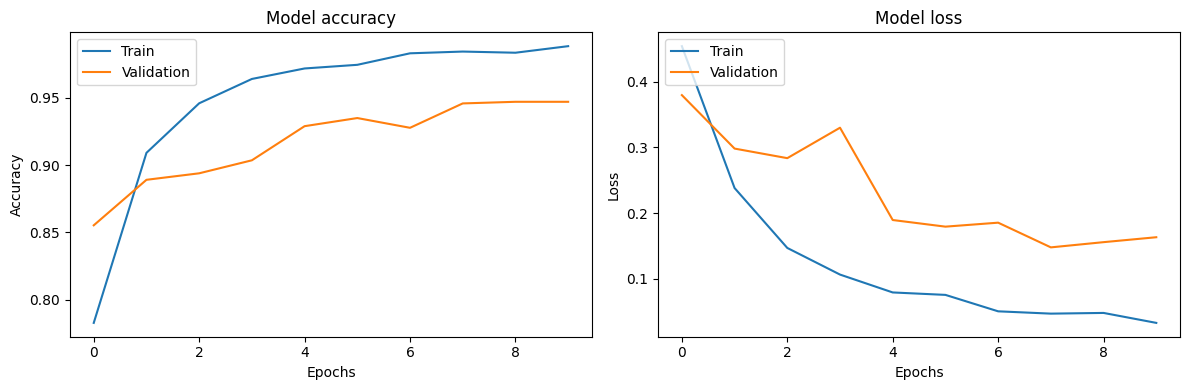

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_by_bagaria.history['accuracy'])
plt.plot(history_by_bagaria.history['val_accuracy'])
plt.title("Model accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_by_bagaria.history['loss'])
plt.plot(history_by_bagaria.history['val_loss'])
plt.title("Model loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [35]:
# added convolutional 256 filter
model_1 = models.Sequential([
    layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [36]:
model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [38]:
history_1 = model_1.fit(training_set,
                   validation_data=val_set,
                   epochs=3 # using simple epoch, to evaluate the addition of 256 filter
                   )

Epoch 1/3
  1/289 ━━━━━━━━━━━━━━━━━━━━ 29:47 6s/step - accuracy: 0.4375 - loss: 0.6945

W0000 00:00:1719734560.154770     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


288/289 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.6486 - loss: 0.6129

W0000 00:00:1719734641.365952     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


289/289 ━━━━━━━━━━━━━━━━━━━━ 98s 319ms/step - accuracy: 0.6492 - loss: 0.6123 - val_accuracy: 0.8094 - val_loss: 0.4661
Epoch 2/3
289/289 ━━━━━━━━━━━━━━━━━━━━ 88s 296ms/step - accuracy: 0.8785 - loss: 0.3043 - val_accuracy: 0.8758 - val_loss: 0.3323
Epoch 3/3
289/289 ━━━━━━━━━━━━━━━━━━━━ 89s 300ms/step - accuracy: 0.9434 - loss: 0.1617 - val_accuracy: 0.8975 - val_loss: 0.3044


In [39]:
history_1 = model_1.fit(training_set,
                   validation_data=val_set,
                   epochs=1 # is better
                   )

289/289 ━━━━━━━━━━━━━━━━━━━━ 90s 305ms/step - accuracy: 0.9626 - loss: 0.1093 - val_accuracy: 0.9144 - val_loss: 0.2531


#### The output seems better, now try for 10 epoch

In [55]:
model_2 = models.Sequential([
    layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [56]:
model_2.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [57]:
history_2 = model_2.fit(training_set,
                   validation_data=val_set,
                   epochs=10 # using simple epoch, to evaluate the addition of 256 filter
                   )

Epoch 1/10
  1/289 ━━━━━━━━━━━━━━━━━━━━ 23:51 5s/step - accuracy: 0.5000 - loss: 0.6928

W0000 00:00:1719736298.499406     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


288/289 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.6354 - loss: 0.6266

W0000 00:00:1719736377.203912     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


289/289 ━━━━━━━━━━━━━━━━━━━━ 94s 308ms/step - accuracy: 0.6360 - loss: 0.6260 - val_accuracy: 0.7961 - val_loss: 0.4612
Epoch 2/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 138s 300ms/step - accuracy: 0.8633 - loss: 0.3298 - val_accuracy: 0.8625 - val_loss: 0.3341
Epoch 3/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 92s 310ms/step - accuracy: 0.9401 - loss: 0.1625 - val_accuracy: 0.8842 - val_loss: 0.3746
Epoch 4/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 90s 306ms/step - accuracy: 0.9626 - loss: 0.1045 - val_accuracy: 0.9011 - val_loss: 0.3227
Epoch 5/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 89s 302ms/step - accuracy: 0.9788 - loss: 0.0657 - val_accuracy: 0.9542 - val_loss: 0.1374
Epoch 6/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 90s 306ms/step - accuracy: 0.9802 - loss: 0.0649 - val_accuracy: 0.9373 - val_loss: 0.1758
Epoch 7/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 92s 309ms/step - accuracy: 0.9858 - loss: 0.0447 - val_accuracy: 0.9469 - val_loss: 0.1475
Epoch 8/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 90s 305ms/step - accuracy: 0.9896 - loss: 0.0362 - va

In [58]:
test_loss_2, test_acc_2 = model_2.evaluate(test_set)
print(f"Test Loss: {test_loss_2:.2f}")
print(f"Test Accurracy: {test_acc_2:.2f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 455ms/step - accuracy: 0.9835 - loss: 0.0358
Test Loss: 0.04
Test Accurracy: 0.99


W0000 00:00:1719737253.769188     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


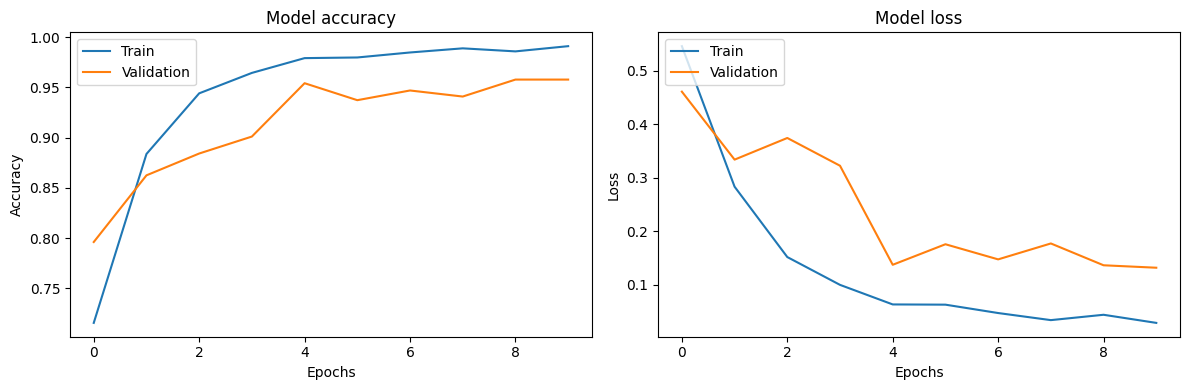

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title("Model accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title("Model loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()